<a href="https://colab.research.google.com/github/khanma1962/Fire-Classification-and-Detection/blob/main/Parallel_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Classification

###A detailed example of how to generate your data in parallel with PyTorch

### https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [1]:
!nvidia-smi

Thu Jun 10 21:09:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory

print(virtual_memory().total / 1e9,  'GB')


27.339640832 GB


In [3]:
# calling all libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import  models, transforms
from torchvision.utils import make_grid
import torch.optim as optim

import os
from PIL import Image
from IPython.display import display

import time
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)

In [4]:
torch.__version__

'1.8.1+cu101'

### Image files directory tree

###https://stackoverflow.com/questions/49073799/pytorch-testing-with-torchvision-datasets-imagefolder-and-dataloader


<pre>.
└──   fire_classification
        ├── test
        │   ├── Fire
        │   │   ├── Fire_0.jpg
        │   │   ├── Fire_1.jpg
        │   │   └── ... (100 files)
        │   └── No_Fire
        │       ├── No_Fire_0.jpg
        │       ├── No_Fire.jpg
        │       └── ... (100 files)       
        │           
        └── train
            ├── Fire
            │   ├── Fire_0.jpg
            │   ├── Fire_1.jpg
            │   └── ... (900 files)
            └── No_Fire
                ├── No_Fire_0.jpg
                ├── No_Fire1.jpg
                └── ... (900 files)</pre>

In [5]:
# Importing the pre-trained model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet50_model = models.resnet50(pretrained= True).to(device)

# Freeze feature parameters
for param in resnet50_model.parameters():
    param.requires_grad = False

# add a new fc of binary class instead of 1000 classes
resnet50_model.fc = nn.Sequential(
                            nn.Linear(2048, 128),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(128, 2),
                            # nn.LogSoftmax(dim=1)).to(device)
                            nn.Sigmoid()).to(device)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.fc.parameters(), lr= 3e-4) # optimizing only the last layers



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [36]:
# Creating class Dataset

class Dataset(torch.utils.data.Dataset):
    "Inhereting Dataset from torch and adding stuff"
    def __init__(self, list_IDs, labels):
        'initialize first'
        print(list_IDs, labels)
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'indicate total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'generate one sampe of data'
        #select sample
        ID = self.list_IDs[index]
        
        root_dir = '/content/drive/MyDrive/Data_Science/projects/Fire Detection System/fire_classification/'

        #load data and label
        print(f'ID is {ID} and index is {index}')
        X = torch.load( root_dir + ID + '.pt')
        y = self.labels[ID]

        return X, y


In [37]:
# test Dataset
list_IDs = ['a', 'b', 'c', 'd', 'e','f']
labels = ['yes', 'no']
mod = Dataset(list_IDs, labels)

print('lenght of list_IDs is',len(mod))
# print(mod[0])


['a', 'b', 'c', 'd', 'e', 'f'] ['yes', 'no']
lenght of list_IDs is 6


In [38]:
# Train the model

# CUDA for pytorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else 'cpu')
torch.backends.cudnn.benchmark = True

# parameters
param = { 'batch_size': 16,
         'shuffle': True,
         'num_workers': 6}

num_epochs = 5 #50

#Datasets
# partition = {'Train': {'Train':['Fire', 'No_Fire']},
#              'Test': {'Test':['Fire', 'No,Fire']}}
partition = {'Train': ['Fire', 'No_Fire'],
             'Test': ['Fire', 'No,Fire']}

labels = {'Fire':1, 'No_Fire':0}


#Generators
training_set = Dataset(partition['Train'], labels)
training_generator = torch.utils.data.DataLoader(training_set, **param)

test_set = Dataset(partition['Test'], labels)
test_generator = torch.utils.data.DataLoader(test_set, **param)

start_time = time.time()

train_loss, test_loss = [], []
train_corr, test_corr = [], []

for i in range(num_epochs):
    trn_corr, tst_corr = 0, 0

    for b, (X_train, y_train) in enumerate(training_generator):

        b +=1 # epoch starts from 1

        #apply the model
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = resnet50_model(X_train)
        loss = criterion(y_pred, y_train)

        # Calculate number of correct predictions
        predicted = torch.max(y_pred.data, 1) [1] # consider only second item
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print interim result
        if b % 100 == 0:
            print(f"epoch:{i:2}, batch:{b:4}, loss:{loss.item():10.8f}, \
            acc:{trn_corr.item()*100 / (batch_size * b):8.3f}%")

    train_loss.append(loss)
    train_corr.append(trn_corr)



    #Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_generator):
            
            #apply the model
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_val = resnet50_model(X_test)

            #check the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
        
    loss = criterion(y_val, y_test)
    test_loss.append(loss)
    test_corr.append(tst_corr)

print(f"Duration: {time.time() - start_time:.0f} seconds") # print elapsed time



['Fire', 'No_Fire'] {'Fire': 1, 'No_Fire': 0}
['Fire', 'No,Fire'] {'Fire': 1, 'No_Fire': 0}
ID is Fire and index is 0


FileNotFoundError: ignored

In [22]:
use_cuda

False

In [25]:
param

{'batch_size': 16, 'num_workers': 6, 'shuffle': True}

In [ ]:

class_names = train_data.classes
class_names

['Fire', 'No_Fire']

In [ ]:
# check the size of batch size and format

for images, labels in train_loader:
    break

images.shape


torch.Size([16, 3, 224, 224])

In [ ]:
x = torch.randn(3, 2,2,2)
print(x.shape,x)
y = torch.transpose(x, 1, 0)
print('\n',y.shape, y)


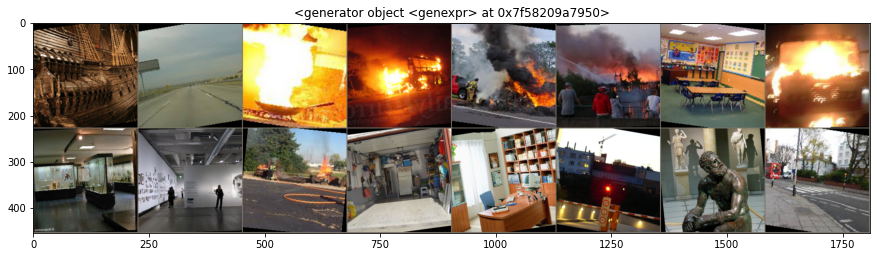

No_Fire No_Fire Fire Fire Fire Fire No_Fire Fire No_Fire No_Fire Fire No_Fire No_Fire No_Fire No_Fire No_Fire 

In [ ]:
# visulaize some of the Fire / No_Fire from train picture using reverse normalization


#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

im = make_grid(images, row=2)

# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821

inv_normalize = transforms.Normalize(
                    mean = [ -0.485/0.229, -0.456/0.224, -0.406/0.225], # -[0.485, 0.456, 0.406] / [0.229, 0.224, 0.225]
                    std  = [ 1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)
plt.figure(figsize = (15, 10))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0))) # to be transposed 1, 2, 0
plt.title( class_names[x] for x in labels)
plt.show()
for lbl in labels:
    print(class_names[lbl], end= ' ') # 0 = Fire, 1= No_Fire
 

### Pre-trained Model

In [ ]:
# check the test accuracy

print('Test Accuracy')
print(f"Test Accuracy: {100*test_corr[-1].item() / ( len(test_data)):.3f}% ")

Test Accuracy
Test Accuracy: 92.462% 


In [ ]:
len(test_data)

199

In [ ]:
test_corr

[tensor(196, device='cuda:0'),
 tensor(188, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(189, device='cuda:0'),
 tensor(194, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(193, device='cuda:0'),
 tensor(187, device='cuda:0'),
 tensor(184, device='cuda:0')]

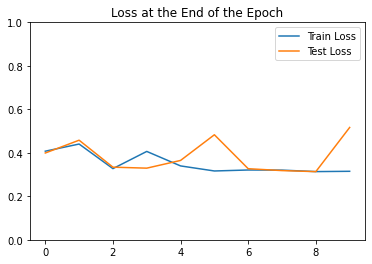

In [ ]:
# Plot Model Peformance - Loss

plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss,  label = 'Test Loss')
plt.title ('Loss at the End of the Epoch')
# to set ylim in matplotlib
axes = plt.gca()
axes.set_ylim([0,1])

plt.legend()
plt.show()


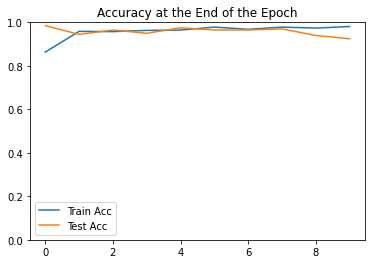

In [ ]:
# Plot Model Peformance - Accuracy

plt.plot([t/len(train_data) for t in train_corr], label= 'Train Acc')
plt.plot([t/len(test_data) for t in test_corr], label= 'Test Acc')
plt.title('Accuracy at the End of the Epoch')

# to set ylim in matplotlib
axes = plt.gca()
axes.set_ylim([0,1])

plt.legend()
plt.show()

In [ ]:
train_corr

[tensor(1542, device='cuda:0'),
 tensor(1712, device='cuda:0'),
 tensor(1710, device='cuda:0'),
 tensor(1720, device='cuda:0'),
 tensor(1723, device='cuda:0'),
 tensor(1747, device='cuda:0'),
 tensor(1729, device='cuda:0'),
 tensor(1747, device='cuda:0'),
 tensor(1739, device='cuda:0'),
 tensor(1752, device='cuda:0')]

Pict is 17 and the size is torch.Size([3, 224, 224])
Predicted Value:0 and class is Fire


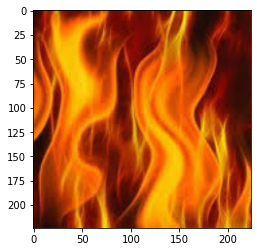

In [ ]:
# cheking one of the random picture

x = np.random.randint(len(test_data))
print(f'Pict is {x} and the size is {test_data[x][0].shape}')
im = inv_normalize(test_loc[x][0])
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))


# evaluate with the model

resnet50_model.eval()
im = im.to(device)
with torch.no_grad():
    # new_pred = resnet50_model(test_data[x][0].view(1, 3, 224, 224)).argmax().to(device)
    new_pred = resnet50_model(im.view(1, 3, 224, 224)).argmax().to(device)

print(f'Predicted Value:{new_pred.item()} and class is {class_names[new_pred.item()]}')